In [1]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)


# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


2.13.0


In [3]:

# Load images from the 'items/' folder
img = np.load('data.npy')
label = np.load('labels.npy', allow_pickle=True)
  # Normalize image pixel values to a float range [0, 1]
img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
img = img[...,::-1]
#plt.imshow(img_array, cmap='gray')

#plt.show()

In [4]:
print(img.shape) # 5200 images of size 96x96 type rgb
print(label.shape)
print(label[1])
print(label[4])

import collections
counter = collections.Counter(label)
counter

for i in range(len(label)):
    if(label[i] == 'healthy'):
        label[i] = 1
    else:
        label[i] = 0



(5200, 96, 96, 3)
(5200,)
healthy
unhealthy


In [5]:
counter = collections.Counter(label) # check if we do all correctly
print(counter)

Counter({1: 3199, 0: 2001})


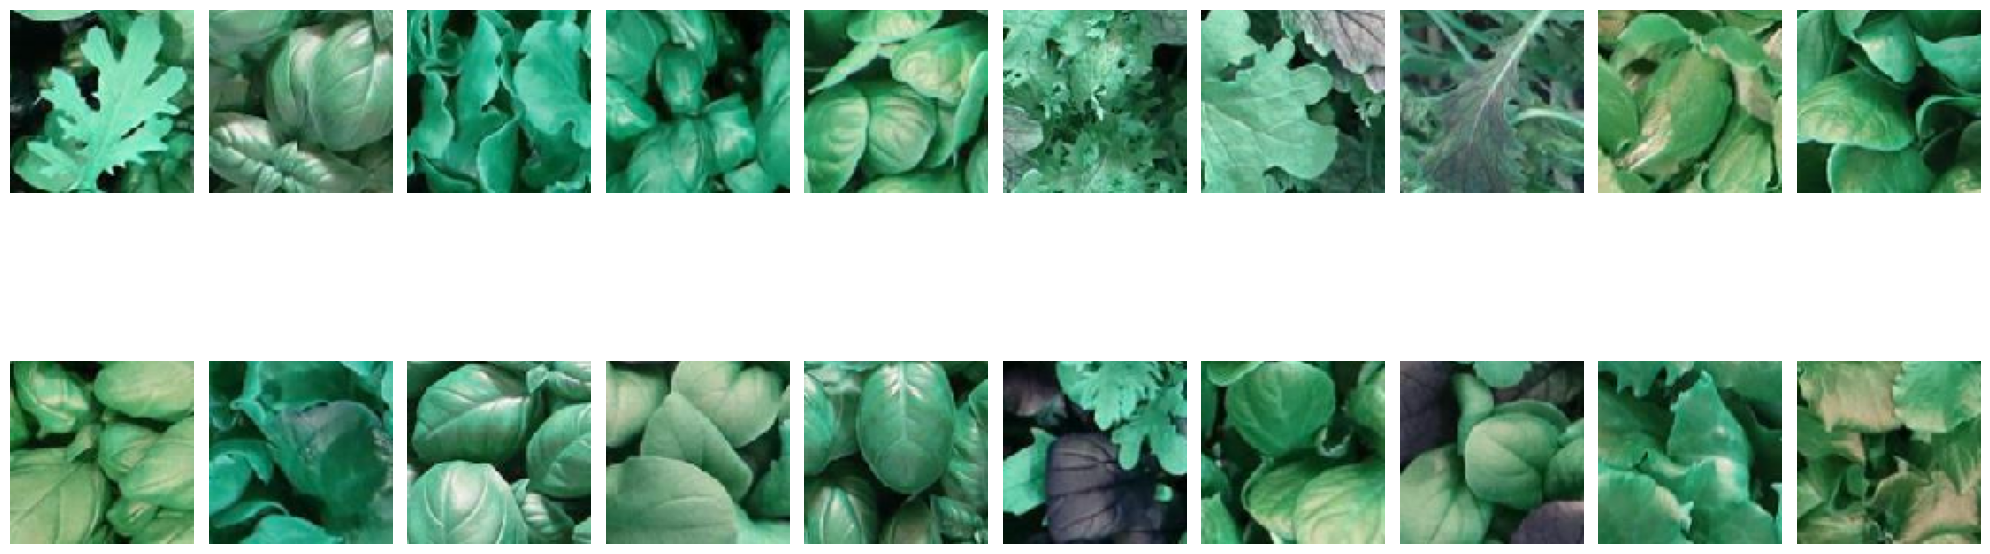

In [23]:
# Number of images to display
num_img = 20
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(img[i], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()



In [6]:
# Concatenate 'animals' and 'items' arrays along axis 0
X = img
# Create labels: 1 for 'animals', 0 for 'items'
y = label

#y = np.concatenate([, np.zeros(len(items))], axis=0)
y = tfk.utils.to_categorical(y,len(np.unique(y)))

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=.25, stratify=np.argmax(y, axis = 1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val, axis = 1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (2600, 96, 96, 3), y_train shape: (2600, 2)
X_val shape: (1300, 96, 96, 3), y_val shape: (1300, 2)
X_test shape: (1300, 96, 96, 3), y_test shape: (1300, 2)


In [7]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape#[1:]
batch_size = 32
epochs = 20

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (96, 96, 3), Output Shape: (2600, 2), Batch Size: 32, Epochs: 20


In [26]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True, mode='auto'),
]

In [12]:
def build_model_1(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [13]:
model = build_model_1()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0       

In [14]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/10
82/82 [==============================] - 21s 250ms/step - loss: 0.6660 - accuracy: 0.6138 - val_loss: 0.6623 - val_accuracy: 0.6154
Epoch 2/10
82/82 [==============================] - 19s 235ms/step - loss: 0.6602 - accuracy: 0.6150 - val_loss: 0.6545 - val_accuracy: 0.6154
Epoch 3/10
82/82 [==============================] - 21s 251ms/step - loss: 0.6525 - accuracy: 0.6165 - val_loss: 0.6169 - val_accuracy: 0.6992
Epoch 4/10
82/82 [==============================] - 20s 250ms/step - loss: 0.6100 - accuracy: 0.6792 - val_loss: 0.5971 - val_accuracy: 0.6900
Epoch 5/10
82/82 [==============================] - 20s 247ms/step - loss: 0.6037 - accuracy: 0.6823 - val_loss: 0.5790 - val_accuracy: 0.7092
Epoch 6/10
82/82 [==============================] - 20s 239ms/step - loss: 0.5863 - accuracy: 0.7012 - val_loss: 0.5677 - val_accuracy: 0.7162
Epoch 7/10
82/82 [==============================] - 20s 242ms/step - loss: 0.5809 - accuracy: 0.7058 - val_loss: 0.6085 - val_accuracy: 0.6677

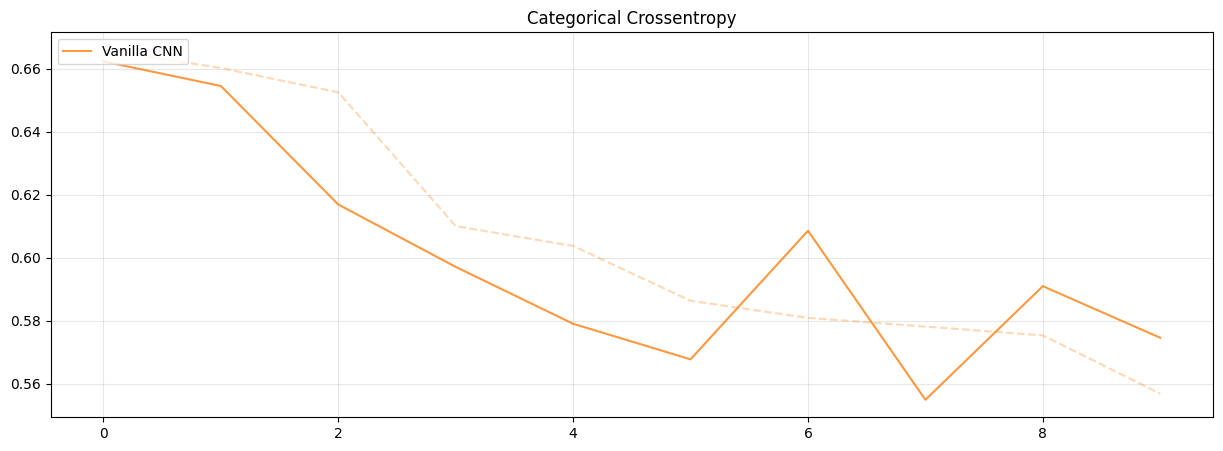

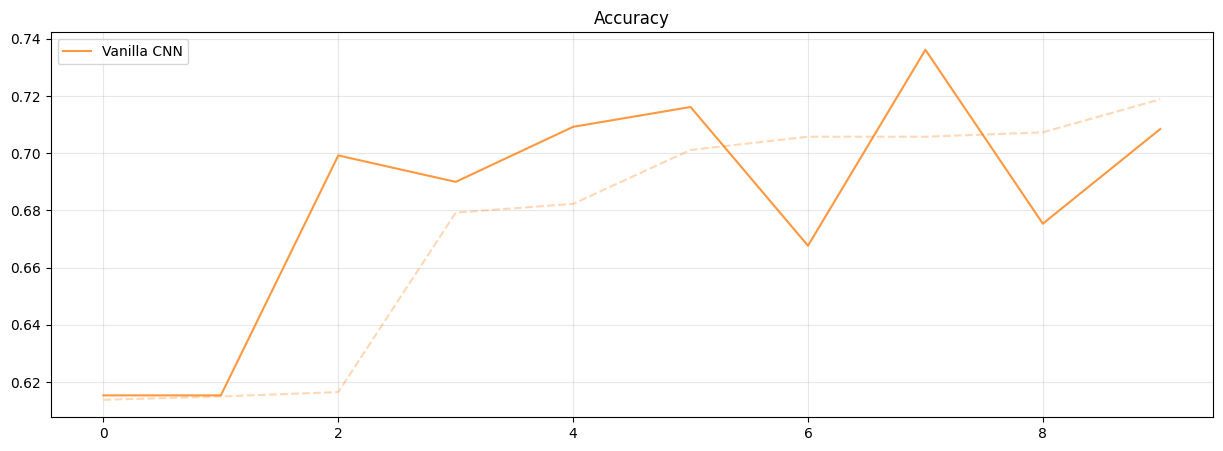

In [15]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [16]:
model.save('trivial_model')
del model

TRANSFER LEARNING FROM MOBILENET

In [27]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

9406464/9406464 [==============================] - 3s 0us/step
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(96, 96, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [29]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
163/163 [==============================] - 13s 66ms/step - loss: 0.5721 - accuracy: 0.7173 - val_loss: 0.4881 - val_accuracy: 0.7777
Epoch 2/200
163/163 [==============================] - 10s 59ms/step - loss: 0.4147 - accuracy: 0.8154 - val_loss: 0.4766 - val_accuracy: 0.7900
Epoch 3/200
163/163 [==============================] - 10s 59ms/step - loss: 0.3683 - accuracy: 0.8419 - val_loss: 0.4482 - val_accuracy: 0.7908
Epoch 4/200
163/163 [==============================] - 10s 59ms/step - loss: 0.3398 - accuracy: 0.8569 - val_loss: 0.4407 - val_accuracy: 0.8100
Epoch 5/200
163/163 [==============================] - 10s 59ms/step - loss: 0.3228 - accuracy: 0.8638 - val_loss: 0.5039 - val_accuracy: 0.7846
Epoch 6/200
163/163 [==============================] - 10s 59ms/step - loss: 0.3174 - accuracy: 0.8623 - val_loss: 0.4332 - val_accuracy: 0.8177
Epoch 7/200
163/163 [==============================] - 10s 59ms/step - loss: 0.3013 - accuracy: 0.8769 - val_loss: 0.4423 - val_ac

In [30]:
# Save the best model
tl_model.save('TransferLearningModel')
del tl_model

In [2]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [8]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8254


AUGMENTATION + FINE TUNING OF A PRETRAINED MODEL

In [9]:
def build_model_with_augmentation(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # add augmentation at the beginning
    preprocessing = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(0,1)),
        tfkl.RandomTranslation(0.2,0.2),
    ], name='preprocessing')

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(preprocessing)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [12]:
augmented_model = build_model_with_augmentation()
augmented_model.summary()
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True, mode='auto'),
]

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 conv0 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 96, 96, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 48, 48, 64)        0       

In [ ]:
aug_history = augmented_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 100,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

In [24]:
efficent = tfk.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3),
    pooling='avg',
    classes=1000,
    classifier_activation="softmax"
)
efficent.trainable = False
tfk.utils.plot_model(efficent, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
inputs = tfkl.Input(shape=(96, 96, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = efficent(inputs, training=False)
#efficent.output_shape[1:]
x = tfk.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = tfkl.layers.Dense(1)(x)
model = tfkl.Model(inputs, outputs)

: 